In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg


In [3]:
file = 'data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


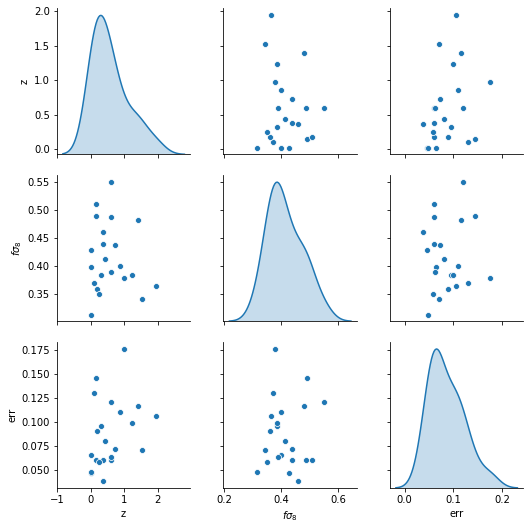

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='relu')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 4
input_z = Input(shape = (1,))
epochs = 100

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
5/5 [==============================] - 0s 53ms/step - loss: 0.0829 - val_loss: 0.0487
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0771 - val_loss: 0.0386
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0741 - val_loss: 0.0318
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0610 - val_loss: 0.0278
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0437 - val_loss: 0.0231
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0301 - val_loss: 0.0187
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0189 - val_loss: 0.0135
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0092
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 11/100
5/5 [=====

5/5 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 85/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 86/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 87/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 88/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 89/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 90/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 91/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 92/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 93/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 94/100
5/5 [============

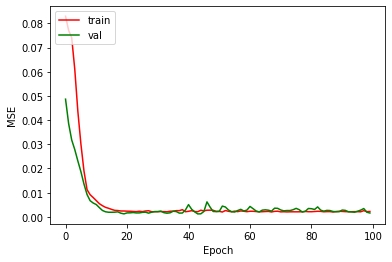

In [13]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_fs8.png", dpi=200)


In [14]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])


(0.0012135582510381935, 0.0019913208670914173)

In [15]:
pred = neural_model.predict(z_test)
pred

array([[0.42495257, 0.06300352],
       [0.44569695, 0.08115245],
       [0.43813348, 0.08632436],
       [0.42773807, 0.08962314],
       [0.38048023, 0.1140263 ]], dtype=float32)

In [16]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [17]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


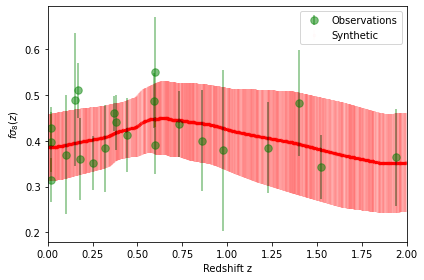

In [18]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()
plt.savefig("synthetic_fs8.png")

In [19]:
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8

In [20]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)


# returns the growth factor as a function of redshift
def GrowthIntegrand_a(a):
    return 1./(self.RHSquared_a(a)*a*a)**(1.5)


def growth(z):
    # Equation 7.77 from Doddie
    af = 1/(1.+z)
    r = intg.quad(GrowthIntegrand_a, 1e-7, af)
    gr = sp.sqrt(Ezlcdm(af))*r[0]  # assume precision is ok
    # If we have Omega_m, let's normalize that way
    gr *= 5/2.*Om
    return gr


def fs8(z):
    return -s8*(1+z)*derivative(growth, z, dx=1e-6)/growth(0)

In [21]:
# z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

# plt.plot(z, fs8(z), label='$\Lambda CDM$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$f\sigma_8(z)$")
# plt.xlim(0, 2)
# plt.tight_layout()
# plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [22]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [23]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [24]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


np.savetxt("annfs850.dat",mookHz, delimiter=" ")

In [25]:
mookHz

array([[0.44548869, 0.42562538, 0.06317476],
       [0.8797059 , 0.43706   , 0.08642026],
       [1.45293874, 0.38781255, 0.11305826],
       [0.33316513, 0.40982574, 0.06839178],
       [0.26294524, 0.40376753, 0.07030766],
       [1.44802376, 0.38830584, 0.11299311],
       [0.95943805, 0.42994761, 0.0887823 ],
       [1.04763138, 0.42004359, 0.09324148],
       [1.08251458, 0.41724539, 0.09566664],
       [1.43421076, 0.38969207, 0.11281008],
       [0.41625212, 0.42265373, 0.06246043],
       [1.68639139, 0.36539698, 0.1142095 ],
       [1.65224038, 0.36817509, 0.11523142],
       [1.49603845, 0.38348716, 0.11362938],
       [0.69721938, 0.44634491, 0.08174266],
       [0.05536365, 0.38772726, 0.07426613],
       [0.68787962, 0.44660217, 0.08193906],
       [1.21027179, 0.40738648, 0.10364029],
       [0.02912445, 0.38623172, 0.07383037],
       [1.859133  , 0.3515889 , 0.10902656],
       [0.64494362, 0.45018053, 0.0811161 ],
       [0.95424493, 0.43056577, 0.08854703],
       [0.

In [26]:
predy_reduced[:,1]

array([0.06317476, 0.08642026, 0.11305826, 0.06839178, 0.07030766,
       0.11299311, 0.0887823 , 0.09324148, 0.09566664, 0.11281008,
       0.06246043, 0.1142095 , 0.11523142, 0.11362938, 0.08174266,
       0.07426613, 0.08193906, 0.10364029, 0.07383037, 0.10902656,
       0.0811161 , 0.08854703, 0.08130095, 0.06901631, 0.10281801,
       0.11192144, 0.07208157, 0.11358813, 0.07179121, 0.08613383,
       0.10817995, 0.06729787, 0.06839178, 0.10279743, 0.07171692,
       0.09187412, 0.08642026, 0.07008384, 0.11255489, 0.06317235,
       0.09101264, 0.10034514, 0.10980342, 0.08571485, 0.07340975,
       0.08044118, 0.10845146, 0.08148348, 0.11351991, 0.06453218],
      dtype=float32)

In [27]:
error  = predy_reduced[:,1]**2
error

array([0.00399105, 0.00746846, 0.01278217, 0.00467744, 0.00494317,
       0.01276744, 0.0078823 , 0.00869397, 0.00915211, 0.01272611,
       0.00390131, 0.01304381, 0.01327828, 0.01291164, 0.00668186,
       0.00551546, 0.00671401, 0.01074131, 0.00545092, 0.01188679,
       0.00657982, 0.00784058, 0.00660984, 0.00476325, 0.01057154,
       0.01252641, 0.00519575, 0.01290226, 0.00515398, 0.00741904,
       0.0117029 , 0.004529  , 0.00467744, 0.01056731, 0.00514332,
       0.00844085, 0.00746846, 0.00491174, 0.0126686 , 0.00399075,
       0.0082833 , 0.01006915, 0.01205679, 0.00734703, 0.00538899,
       0.00647078, 0.01176172, 0.00663956, 0.01288677, 0.0041644 ],
      dtype=float32)

In [28]:
diagcov = np.diag(error) #inverso
np.savetxt("annfs8_cov50.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

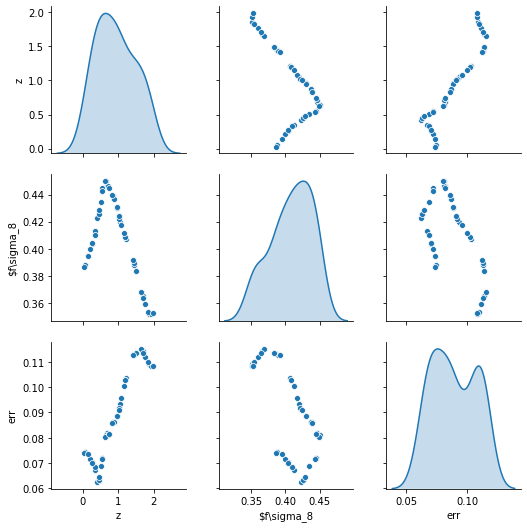

In [29]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
plt.savefig("dist50fs8fake.png")